In [35]:
import os
from tqdm import tqdm
import pickle
import random
from typing import Tuple

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import networkx as nx

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns
from molmass import Formula

import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [34]:
store_dir

'/g/alexandr/tim/metaspace_evaluation/230201'

In [2]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
hmdb_v4 = pd.read_csv(os.path.join(data_dir, 'databases/HMDB_v4.csv'), index_col=None).set_index('chemical_formula')
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [3]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [4]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=15)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

In [5]:
# adata = utils.make_ion_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)

adata = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.2, only_onSample=True)
adata.var = adata.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

100%|██████████| 7443/7443 [00:09<00:00, 772.56it/s]


10865  features


100%|██████████| 7443/7443 [00:37<00:00, 199.48it/s]
/home/trose/projects/metaspace_evaluation/utils.py:186: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mol_data.to_numpy(), var=pd.DataFrame(mol_features), obs=mdt.loc[mol_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
sc.pp.filter_genes(adata, min_cells=100) # 200
sc.pp.filter_cells(adata, min_genes=20) # 50
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.tl.pca(adata)
#sc.external.pp.bbknn(adata, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
adata

AnnData object with n_obs × n_vars = 4437 × 1631
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

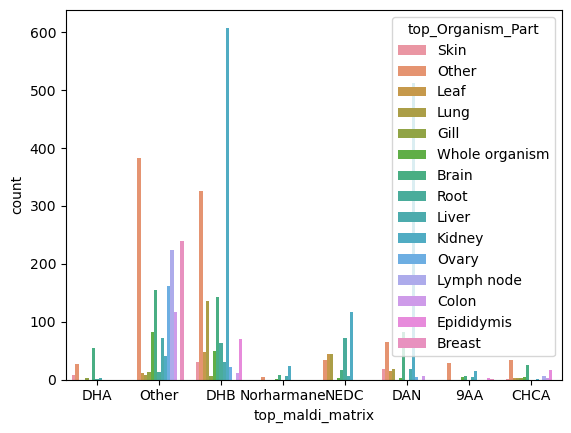

In [8]:
sns.countplot(data=adata.obs, x='top_maldi_matrix', hue='top_Organism_Part')

# Positive

In [9]:
adata_pos = adata[adata.obs['Polarity']=='Positive',:]

sc.pp.filter_genes(adata_pos, min_cells=100) # 200
sc.pp.filter_cells(adata_pos, min_genes=20) # 50
#sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_pos.var['mass'] = [Formula(x).mass for x in adata_pos.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [43]:
pd.DataFrame(adata_pos.var.index).to_csv(os.path.join(enrichment_dir, f'bg_pos.csv'))

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

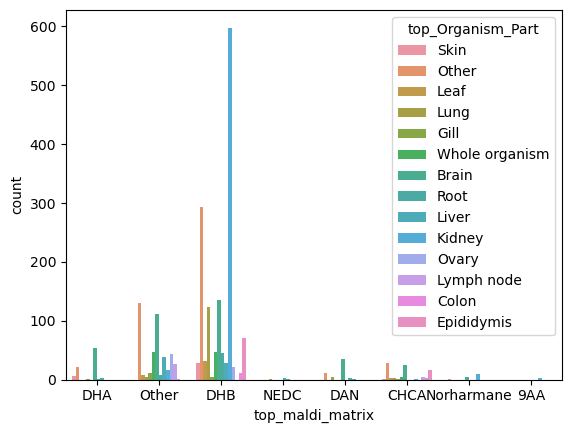

In [11]:
sns.countplot(data=adata_pos.obs, x='top_maldi_matrix', hue='top_Organism_Part')

## DHB

In [12]:
adata_pos_dhb = adata_pos[adata_pos.obs['top_maldi_matrix']=='DHB',:]

sc.pp.neighbors(adata_pos_dhb, metric='cosine')
sc.tl.leiden(adata_pos_dhb)
sc.tl.umap(adata_pos_dhb)

In [13]:
# Updated min mass

min_mass_dict = {}
max_mass_dict = {}

for i in range(adata_pos_dhb.X.shape[0]):
    ds_id = adata_pos_dhb.obs.index[i]
    dataslice = adata_pos_dhb.X[i, :] > 0
    
    min_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].max()
    
adata_pos_dhb.obs['minmass'] = pd.Series(min_mass_dict)
adata_pos_dhb.obs['maxmass'] = pd.Series(max_mass_dict)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


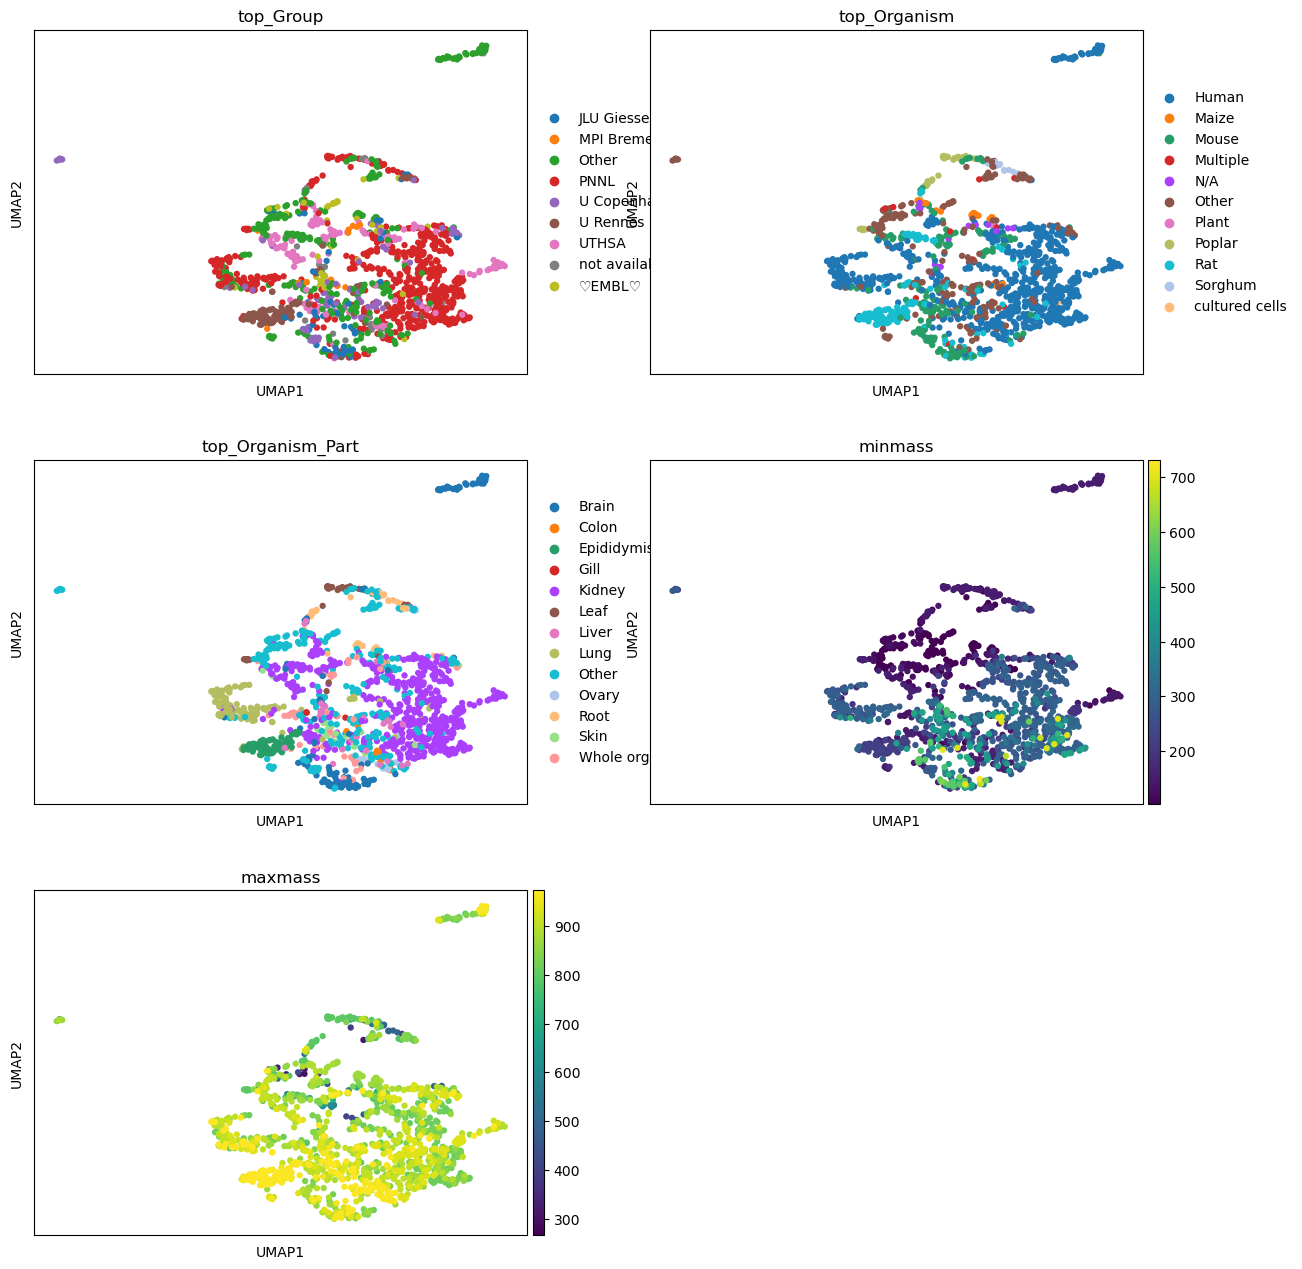

In [14]:
sc.pl.umap(adata_pos_dhb, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [15]:
adata_pos.var['mass'][dataslice].min()

136.151519

<AxesSubplot: xlabel='minmass', ylabel='Count'>

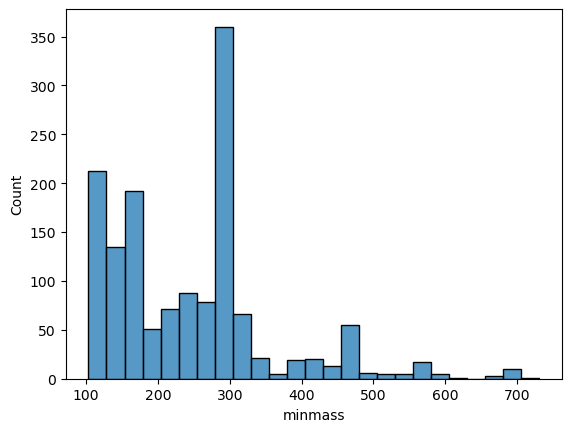

In [16]:
sns.histplot(data=adata_pos_dhb.obs, x='minmass')

<AxesSubplot: xlabel='maxmass', ylabel='Count'>

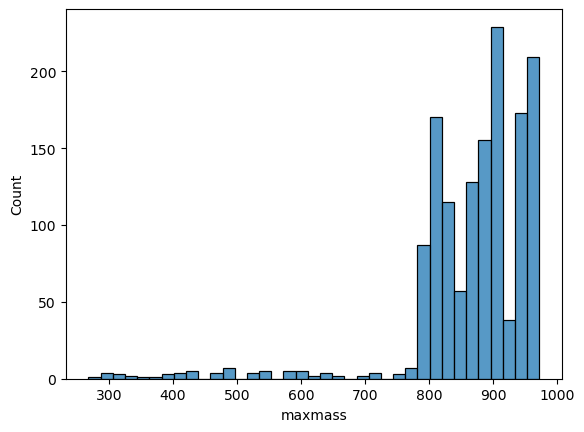

In [17]:
sns.histplot(data=adata_pos_dhb.obs, x='maxmass')

## MZ range

In [18]:
(adata_pos_dhb.var['mass'] > 100) & (adata_pos_dhb.var['mass'] > 100)

molecule
C42H76NO8P     True
C18H16O9S      True
C49H97N2O6P    True
C49H80NO8P     True
C58H94O6       True
               ... 
C3H10NO4P      True
C43H76NO7P     True
C32H49NO5      True
C61H104O6      True
C47H95N2O6P    True
Name: mass, Length: 714, dtype: bool

In [19]:
adata_pos_dhb_mz = adata_pos_dhb[:,adata_pos_dhb.var['mass'] < 1400]
adata_pos_dhb_mz = adata_pos_dhb_mz[:,adata_pos_dhb_mz.var['mass'] > 100]

sc.pp.pca(adata_pos_dhb_mz)
sc.pp.neighbors(adata_pos_dhb_mz, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz)
sc.tl.umap(adata_pos_dhb_mz)

In [20]:
adata_pos_dhb_mz

AnnData object with n_obs × n_vars = 1439 × 714
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


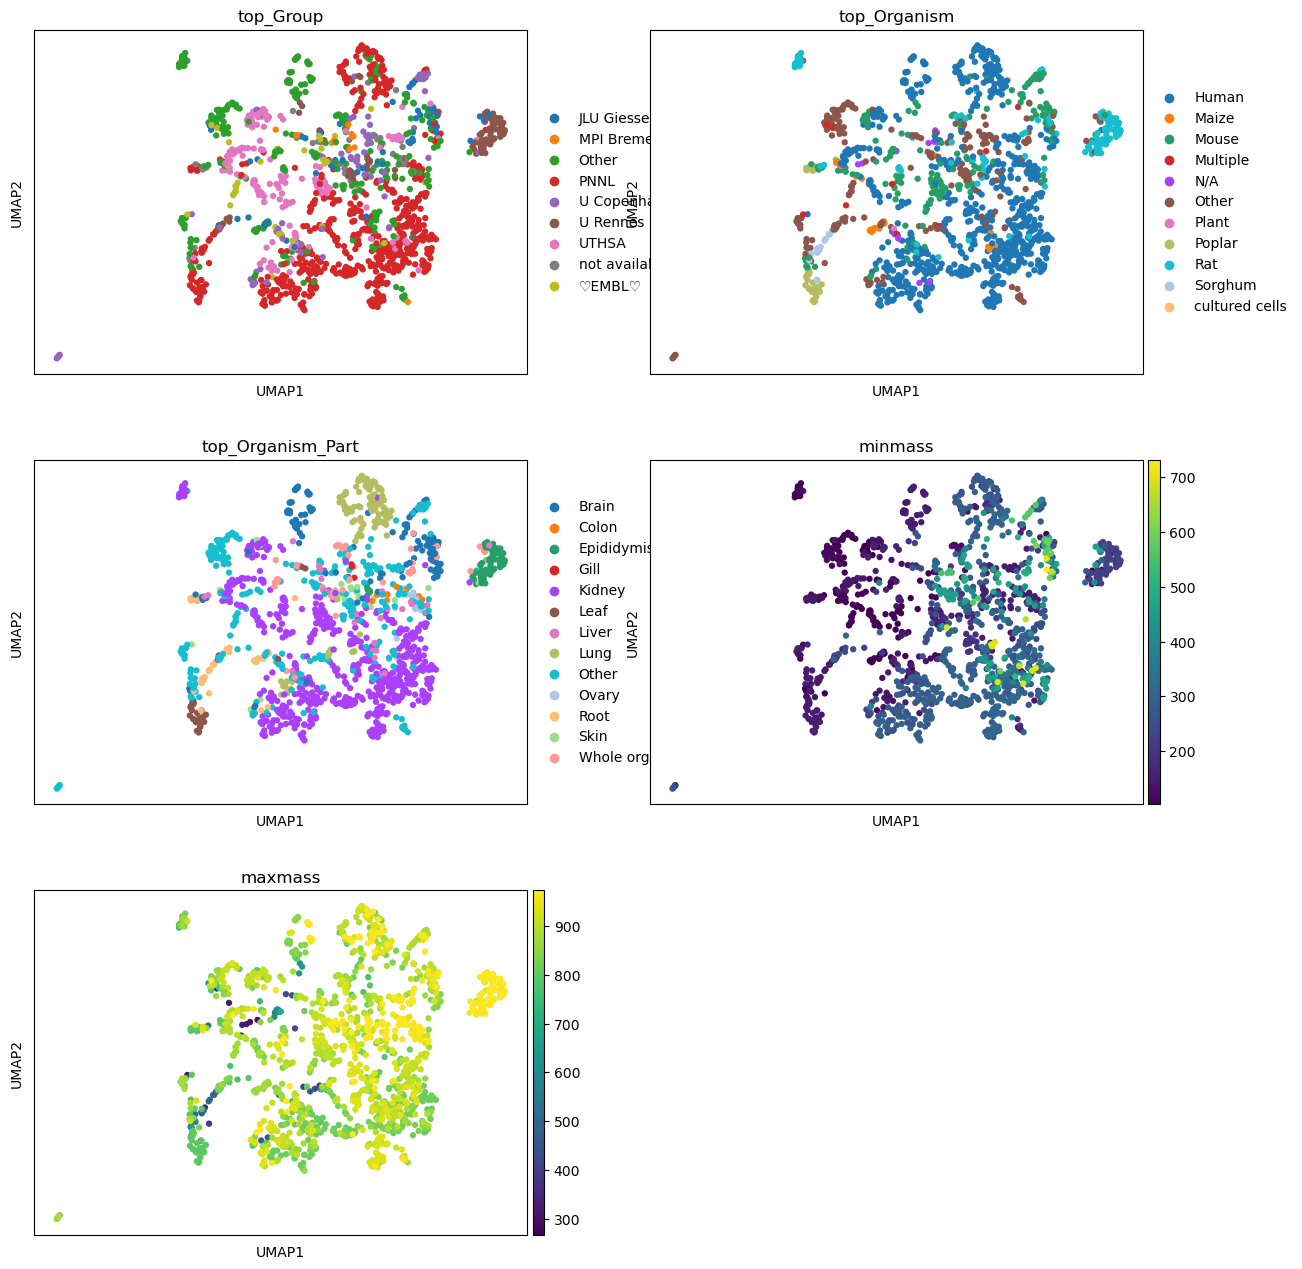

In [21]:
adat = adata_pos_dhb_mz
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Select tissues

In [22]:
# Tissues
tissue_list = ['Brain', 'Colon', 'Epididymis', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Skin']


adata_pos_dhb_mz_tissue = adata_pos_dhb_mz[adata_pos_dhb_mz.obs['top_Organism_Part'].isin(tissue_list), :]

sc.pp.pca(adata_pos_dhb_mz_tissue)
sc.pp.neighbors(adata_pos_dhb_mz_tissue, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz_tissue)
sc.tl.umap(adata_pos_dhb_mz_tissue)

In [23]:
adata_pos_dhb_mz_tissue

AnnData object with n_obs × n_vars = 1017 × 714
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
np.isnan(adata_pos_dhb_mz.X).any()

False

In [25]:
pd.get_dummies(adata_pos_dhb_mz_tissue.obs['top_Organism_Part']).to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


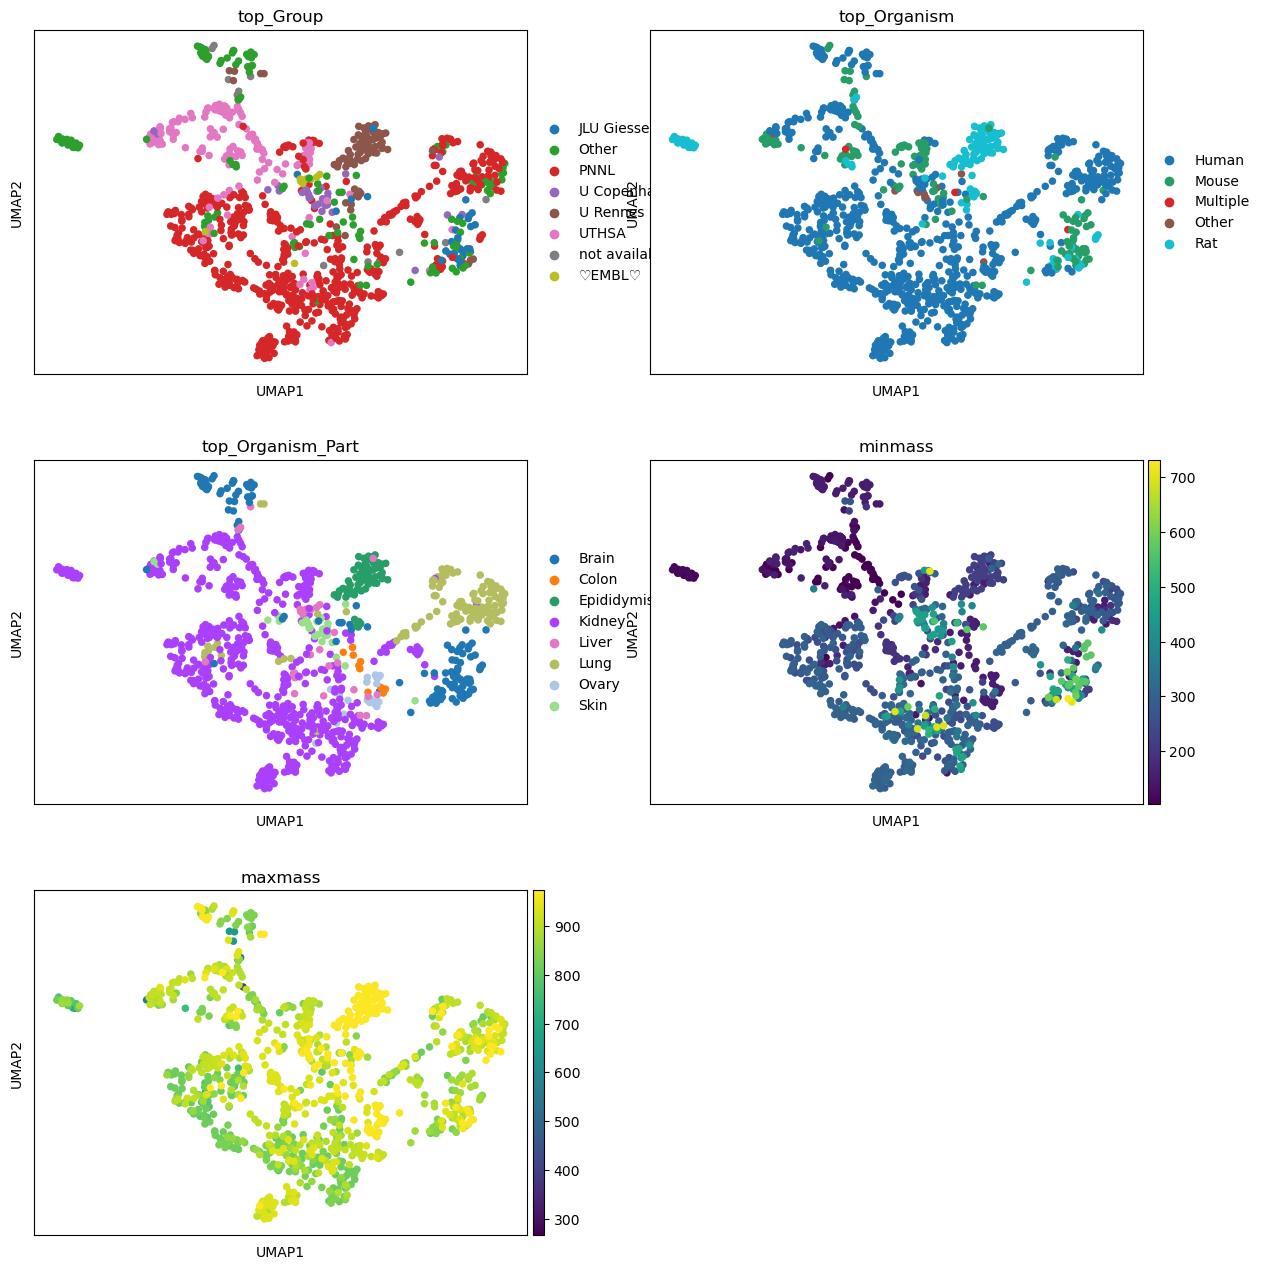

In [26]:
adat = adata_pos_dhb_mz_tissue
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Ignored: Correcting lab effect

Does not make sense with combat, maybe try other tools later

In [27]:
# adata_pos_dhb_mz_tissue_cor = adata_pos_dhb_mz_tissue.copy()

In [28]:
#tmp = sc.pp.combat(adata_pos_dhb_mz_tissue_cor, 
#             key='top_Group', 
#             inplace=False,
#             covariates=['top_Organism_Part']
#            )

#adata_pos_dhb_mz_tissue_cor.X = tmp

In [29]:
#sc.pp.pca(adata_pos_dhb_mz_tissue_cor)
#sc.pp.neighbors(adata_pos_dhb_mz_tissue_cor, metric='cosine')
#sc.tl.leiden(adata_pos_dhb_mz_tissue_cor)
#sc.tl.umap(adata_pos_dhb_mz_tissue_cor)


In [30]:
#adat = adata_pos_dhb_mz_tissue_cor
#min_mass_dict = {}
#max_mass_dict = {}

#for i in range(adat.X.shape[0]):
#    ds_id = adat.obs.index[i]
#    dataslice = adat.X[i, :] > 0
    
#    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
#    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
#adat.obs['minmass'] = pd.Series(min_mass_dict)
#adat.obs['maxmass'] = pd.Series(max_mass_dict)

#sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
#           ncols=2)

## Tissue prototyping

In [31]:
tissue_mol_freq = {}
tissue_top_datasets = {}

mol_freq_cutoff = 0.1
top_ds_cutoff = 0.2


### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


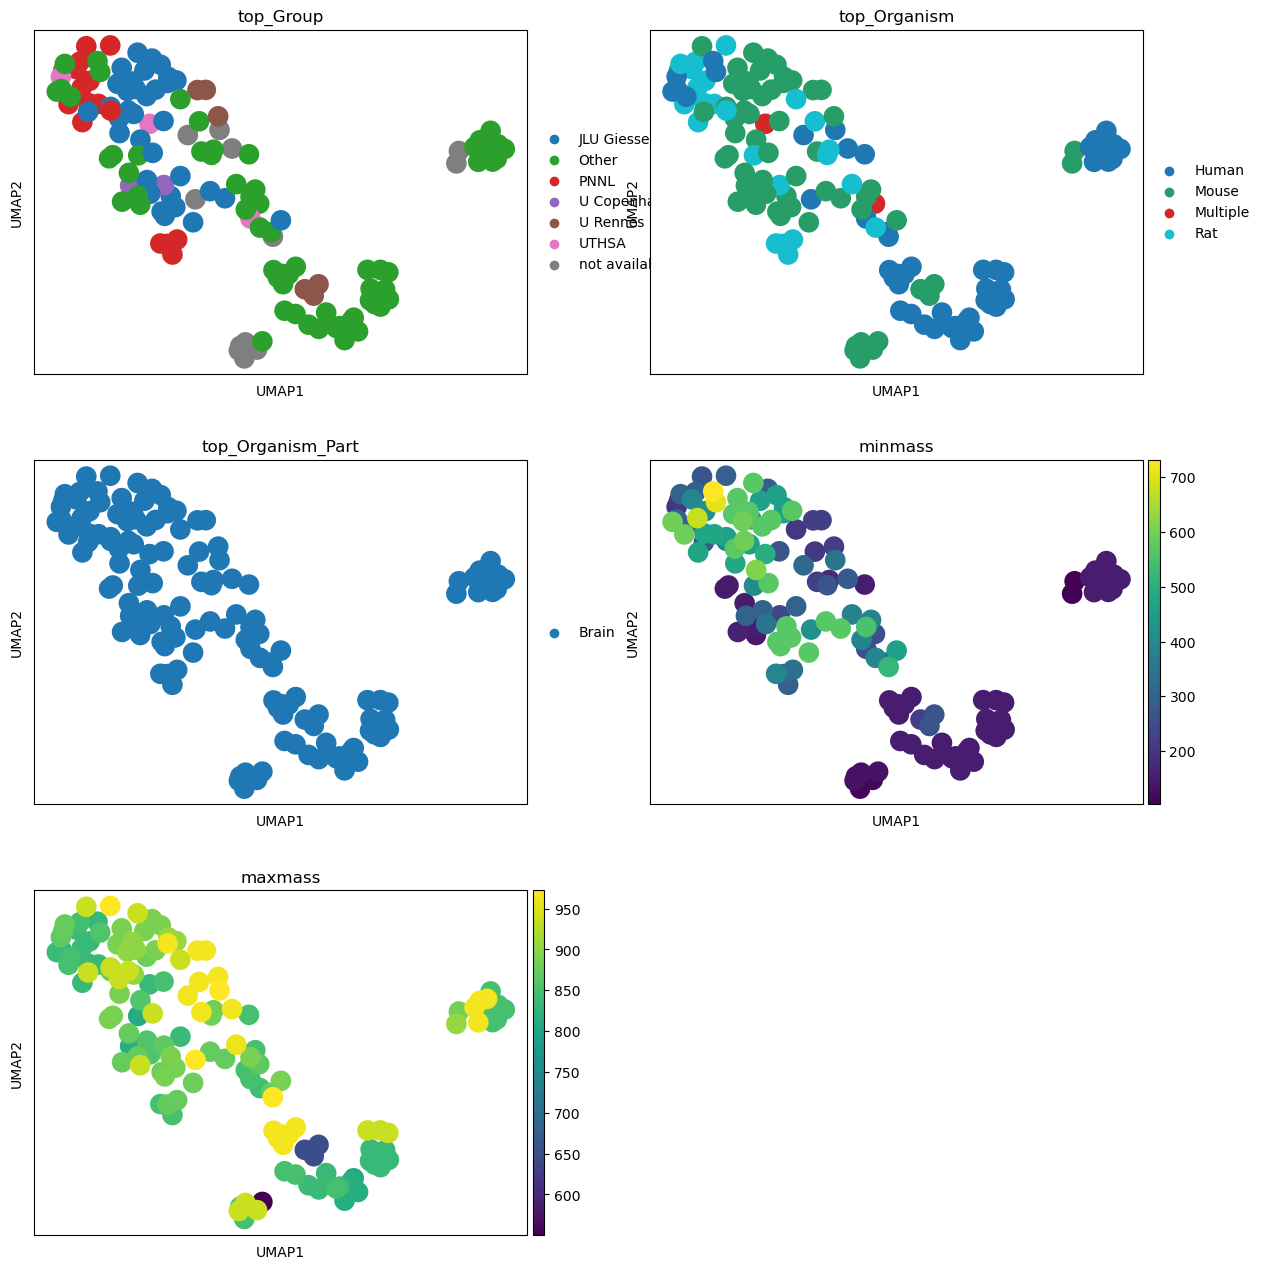

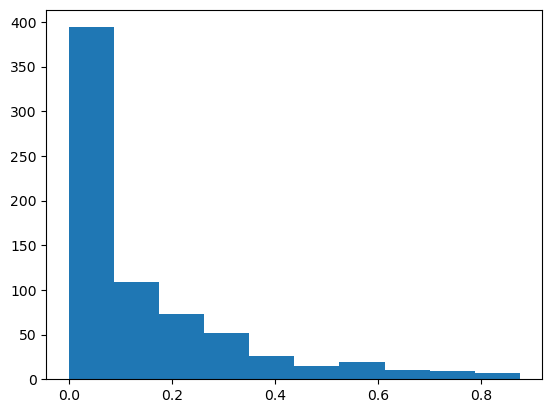

In [44]:
tissue = 'Brain'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [67]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C13H17NO3  -  ['Pandamarilactam 3x']
C46H90NO10P  -  ['PS(16:0/24:0)', 'PS(18:0/22:0)', 'PS(20:0/20:0)', 'PS(22:0/18:0)']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C27H48NO7P  -  ['LysoPE(0:0/22:4(7Z,10Z,13Z,16Z))', 'LysoPE(22:4(7Z,10Z,13Z,16Z)/0:0)']
C23H46NO7P  -  ['LysoPE(0:0/18:1(11Z))', 'LysoPE(0:0/18:1(9Z))', 'LysoPE(18:1(11Z)/0:0)', 'LysoPE(18:1(9Z)/0:0)']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C10H14N5O8P  -  ['Guanosine monophosphate', '8-Oxo-dGMP', 'Cyclic pyranopterin monophosphate', "Guanosine 2'-monop

In [51]:
adat

AnnData object with n_obs × n_vars = 136 × 708
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Colon


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


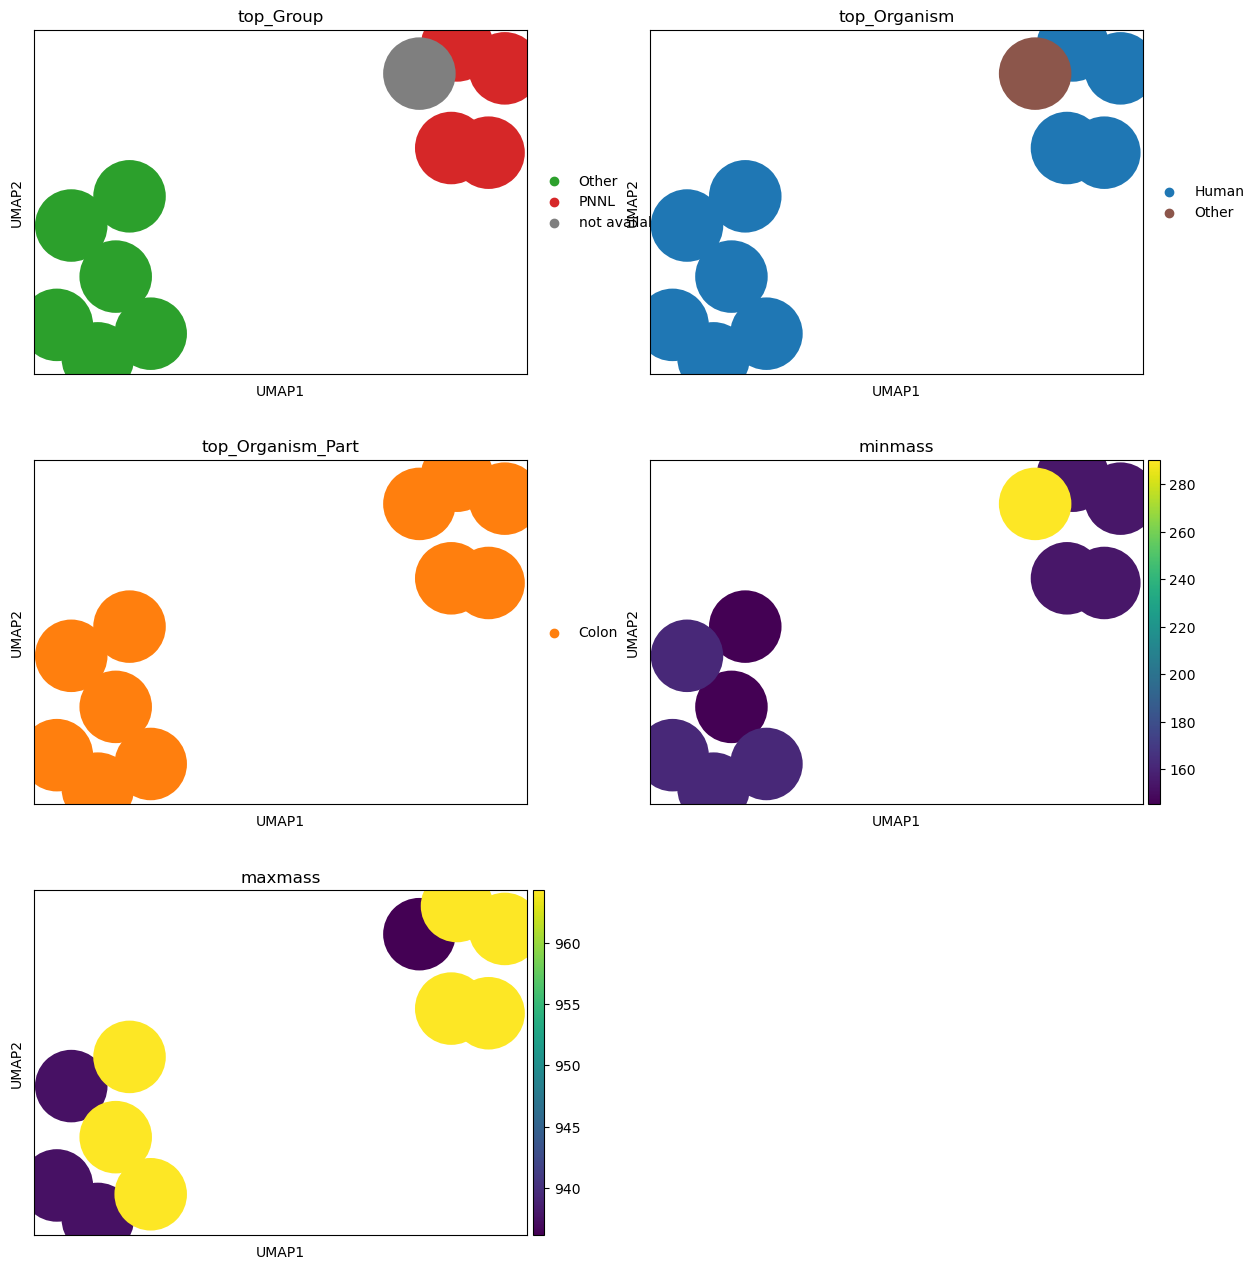

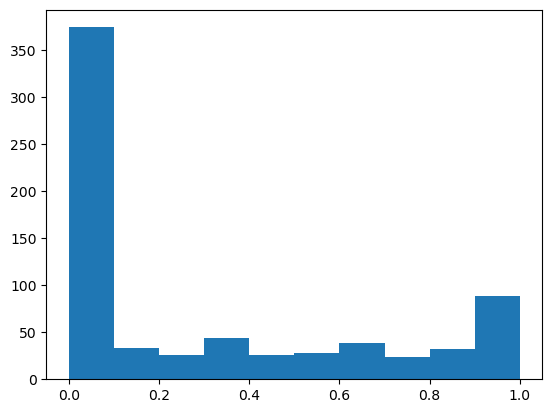

In [45]:
tissue = 'Colon'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [70]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C37H70O5  -  ['DG(14:0/20:1(11Z)/0:0)', 'DG(14:1(9Z)/20:0/0:0)', 'DG(16:0/18:1(11Z)/0:0)', 'DG(16:0/18:1(9Z)/0:0)']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C13H17NO3  -  ['Pandamarilactam 3x']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C37H66O4  -  ['Montecristin']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C43H76NO8P  -  ['PC(15:0/20:5(5Z,8Z,11Z,14Z,17Z))', 'PC(20:5(5Z,8Z,11Z,14Z,17Z)/15:0)', 

### Epididymis

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


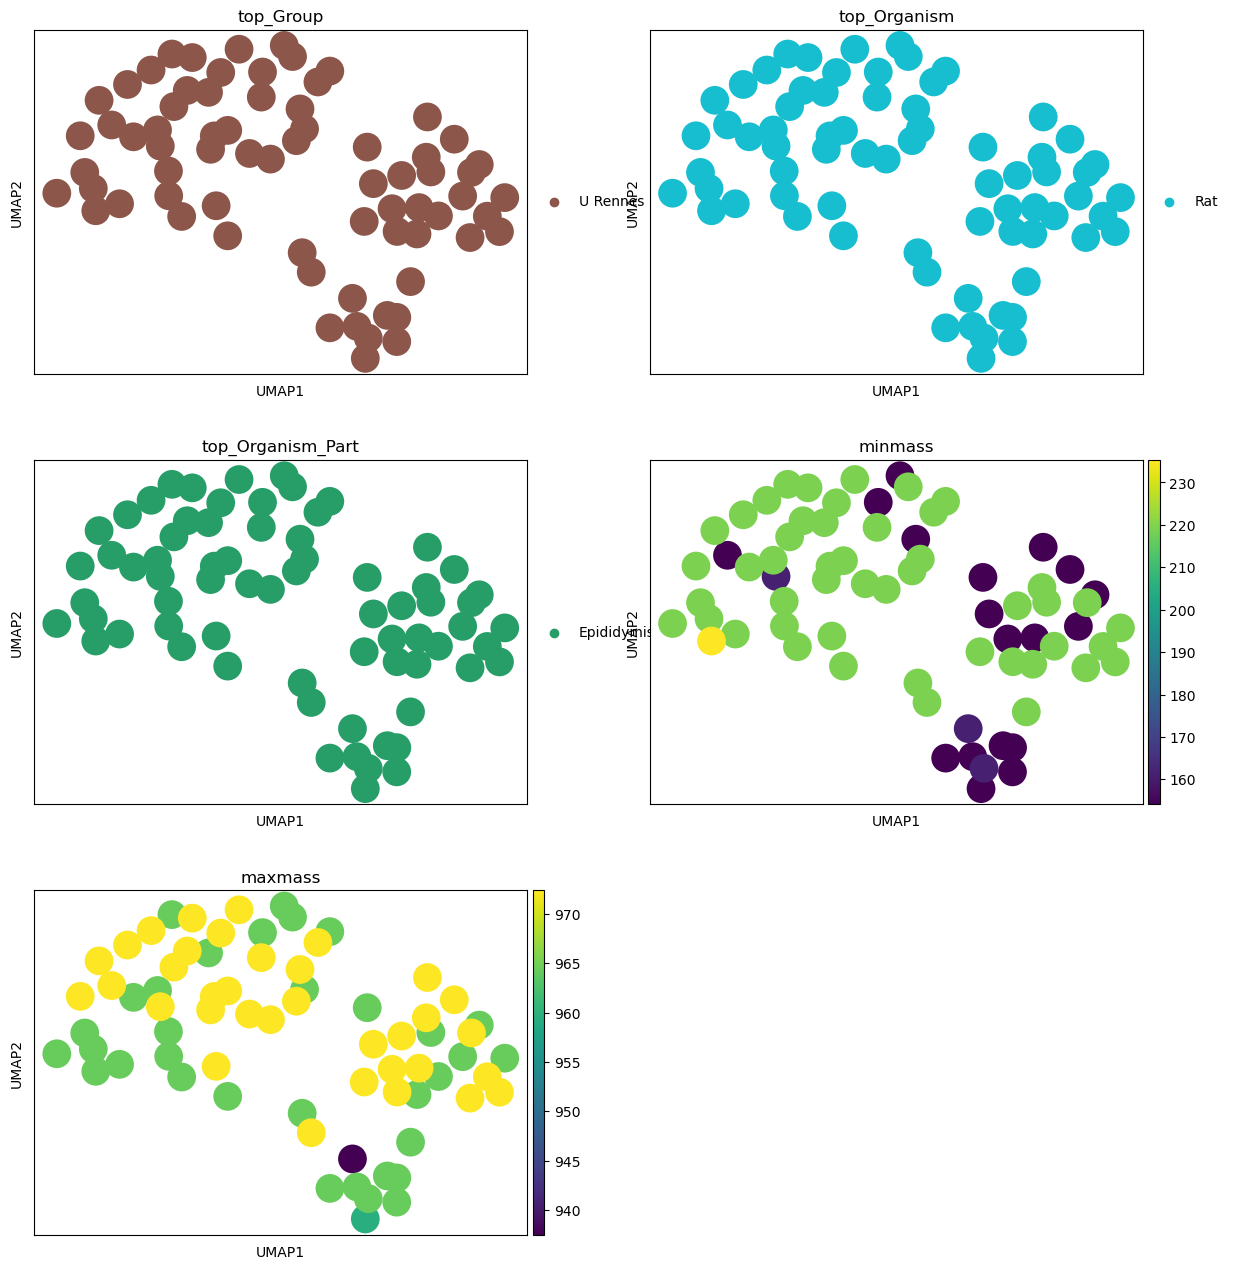

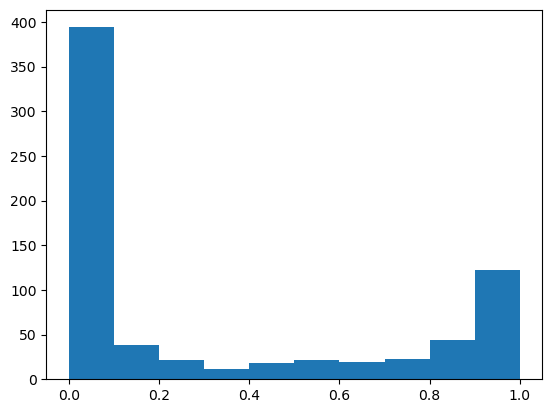

In [46]:
tissue = 'Epididymis'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [72]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C13H17NO3  -  ['Pandamarilactam 3x']
C41H74NO8P  -  ['PC(15:0/18:4(6Z,9Z,12Z,15Z))', 'PC(18:4(6Z,9Z,12Z,15Z)/15:0)', 'PE(14:0/22:4(7Z,10Z,13Z,16Z))', 'PE(16:0/20:4(5Z,8Z,11Z,14Z))']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C48H88NO7P  -  ['PC(22:4(7Z,10Z,13Z,16Z)/P-18:0)', 'PC(P-18:0/22:4(7Z,10Z,13Z,16Z))', 'PC(O-20:1(11Z)/20:4(8Z,11Z,14Z,17Z))']
C27H48NO7P  -  ['LysoPE(0:0/22:4(7Z,10Z,13Z,16Z))', 'LysoPE(22:4(7Z,10Z,13Z,16Z)/0:0)']
C23H46NO7P  -  ['LysoPE(0:0/18:1(11Z))', 'LysoPE(0:0/18:1(9Z))', 'LysoPE(18:1(11Z)/0:0)', 'LysoPE(18:1(9Z)/0:0)']
C43H74O4  -  ['5-Hydroxy-7-methoxy-2-tritriacontyl-4H-1-benzopyran-4-one']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C30H54NO7P  -  ['LysoPC(22:4(7Z,10Z,13Z,16Z)/0:0)']
C47H93N2O6P  -  ['SM(d18:1/24:1(15Z))', 'SM(d18:2(4E,14Z)/24:0)']
C26H54NO7P  -  ['LysoPC(18:0/0:0)', 'LysoPC(0:0/18:0)', 'Platelet-activating 

### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


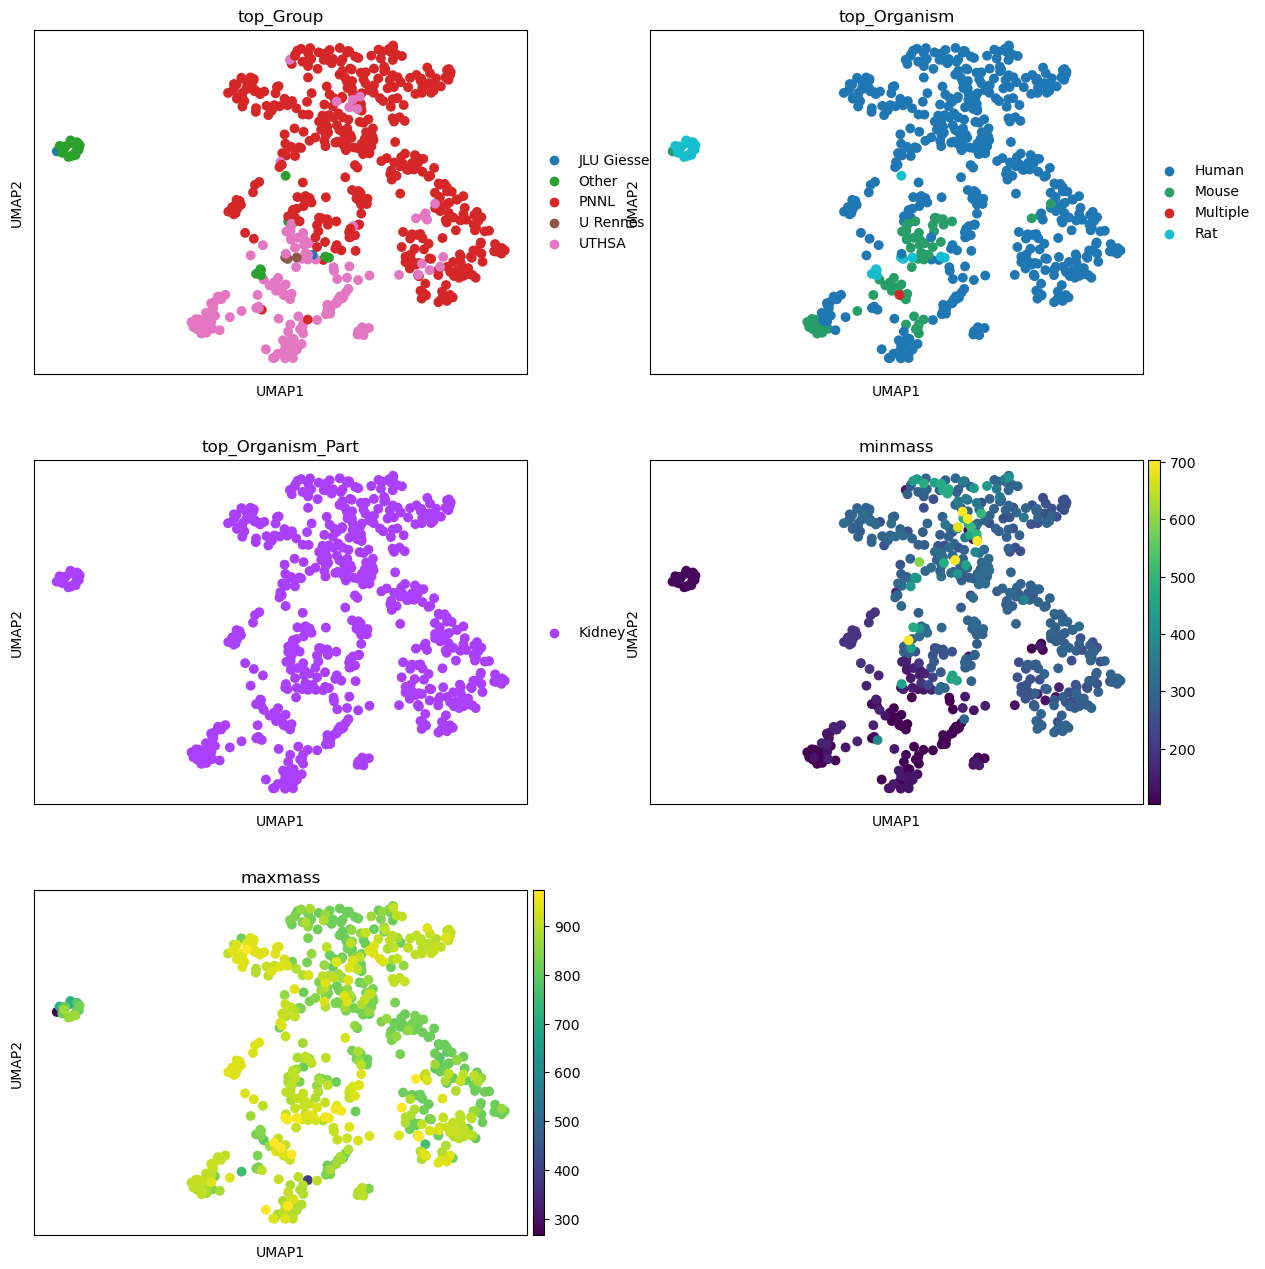

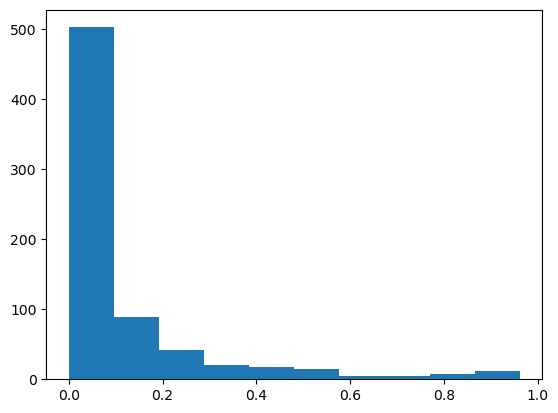

In [47]:
tissue = 'Kidney'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [74]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C26H50NO7P  -  ['LysoPC(18:2(9Z,12Z)/0:0)', 'LysoPC(0:0/18:2(9Z,12Z))']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C41H74NO8P  -  ['PC(15:0/18:4(6Z,9Z,12Z,15Z))', 'PC(18:4(6Z,9Z,12Z,15Z)/15:0)', 'PE(14:0/22:4(7Z,10Z,13Z,16Z))', 'PE(16:0/20:4(5Z,8Z,11Z,14Z))']
C43H71O8P  -  ['PA(18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(18:2(9Z,12Z)/22:5(4Z,7Z,10Z,13Z,16Z))', 'PA(18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z))']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C37H66O4  -  ['Montecristin']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C43H76NO8P  -  ['PC(15:0/20:5(5Z,8Z,11Z,14Z,17Z))', 'PC(20:5(5Z,8Z,11Z,14Z,17Z)/15:0)', 'PE(16:0/22:5(

### Liver

In [291]:
mol_freq.max()

0.9615384615384616

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


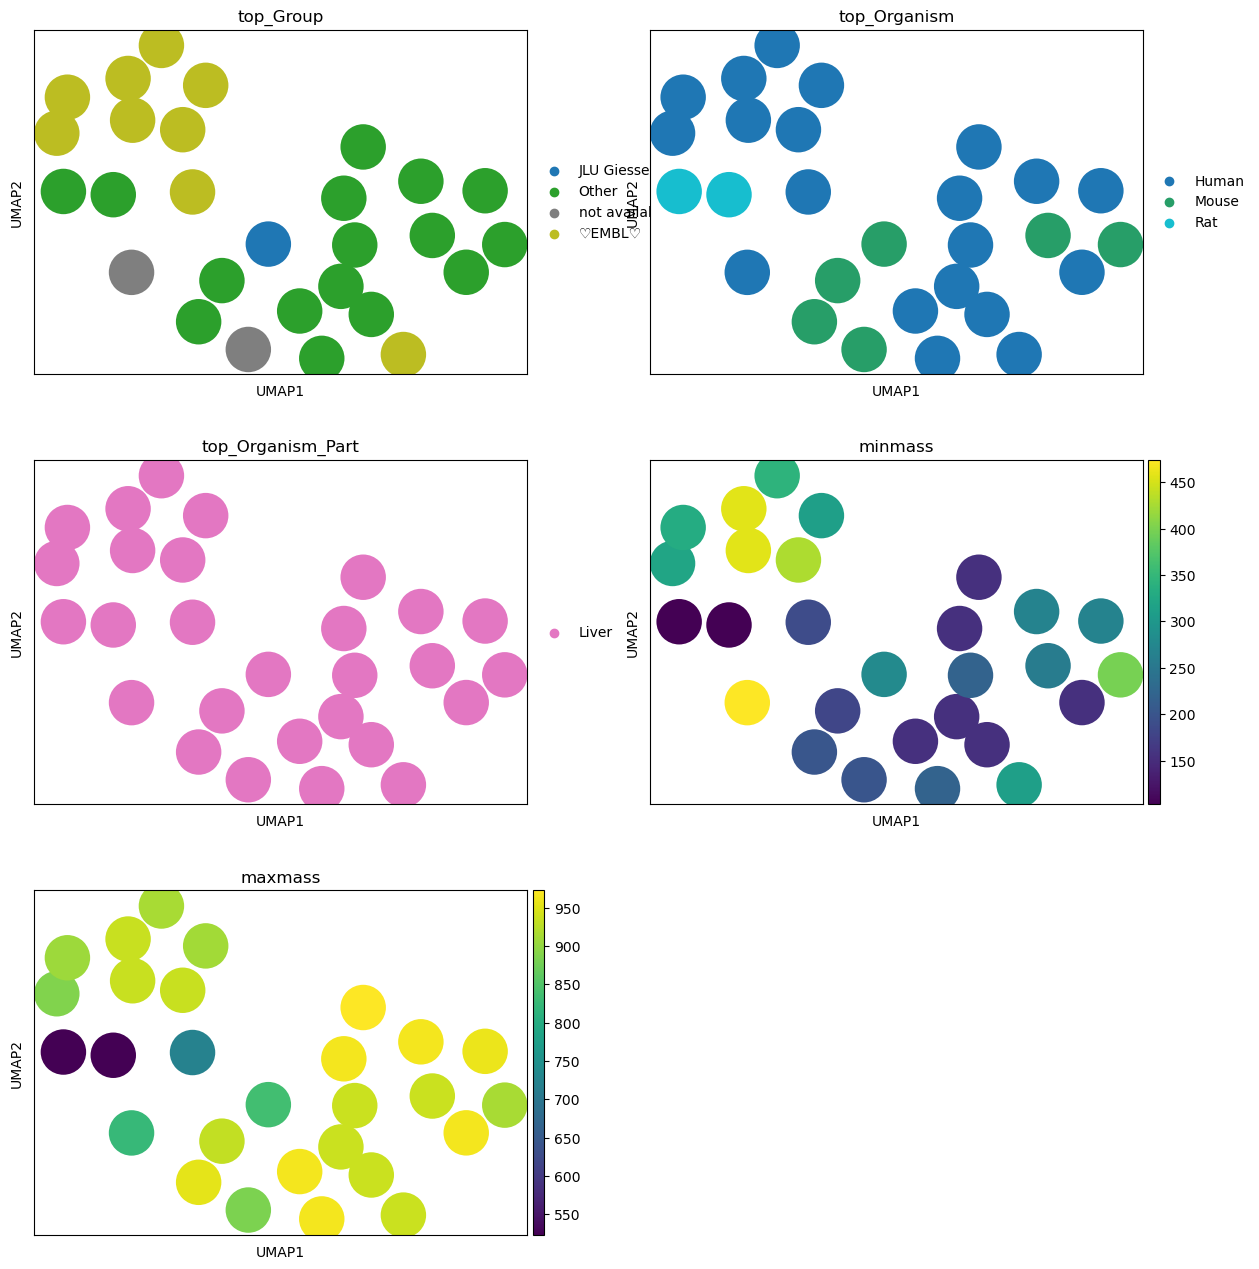

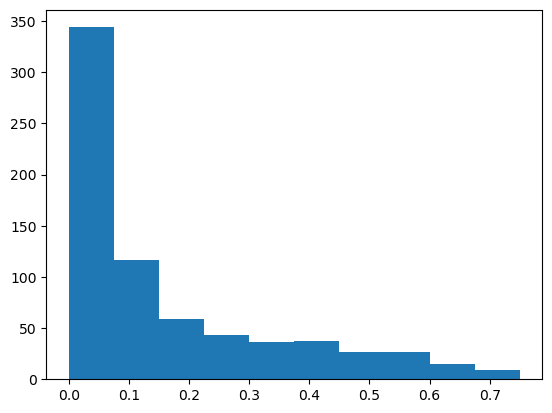

In [48]:
tissue = 'Liver'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [76]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C26H50NO7P  -  ['LysoPC(18:2(9Z,12Z)/0:0)', 'LysoPC(0:0/18:2(9Z,12Z))']
C37H70O5  -  ['DG(14:0/20:1(11Z)/0:0)', 'DG(14:1(9Z)/20:0/0:0)', 'DG(16:0/18:1(11Z)/0:0)', 'DG(16:0/18:1(9Z)/0:0)']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C35H68O5  -  ['DG(14:0/18:0/0:0)', 'DG(16:0/16:0/0:0)', 'DG(18:0/14:0/0:0)', 'Glycerol 1,3-dihexadecanoate']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C42H80O6  -  ['Glycerol tritridecanoate', 'TG(a-21:0/8:0/10:0)[rac]', 'TG(21:0/8:0/10:0)', 'TG(i-21:0/10:0/8:0)']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C43H76NO8P  -  ['PC(15:0/20:5

### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


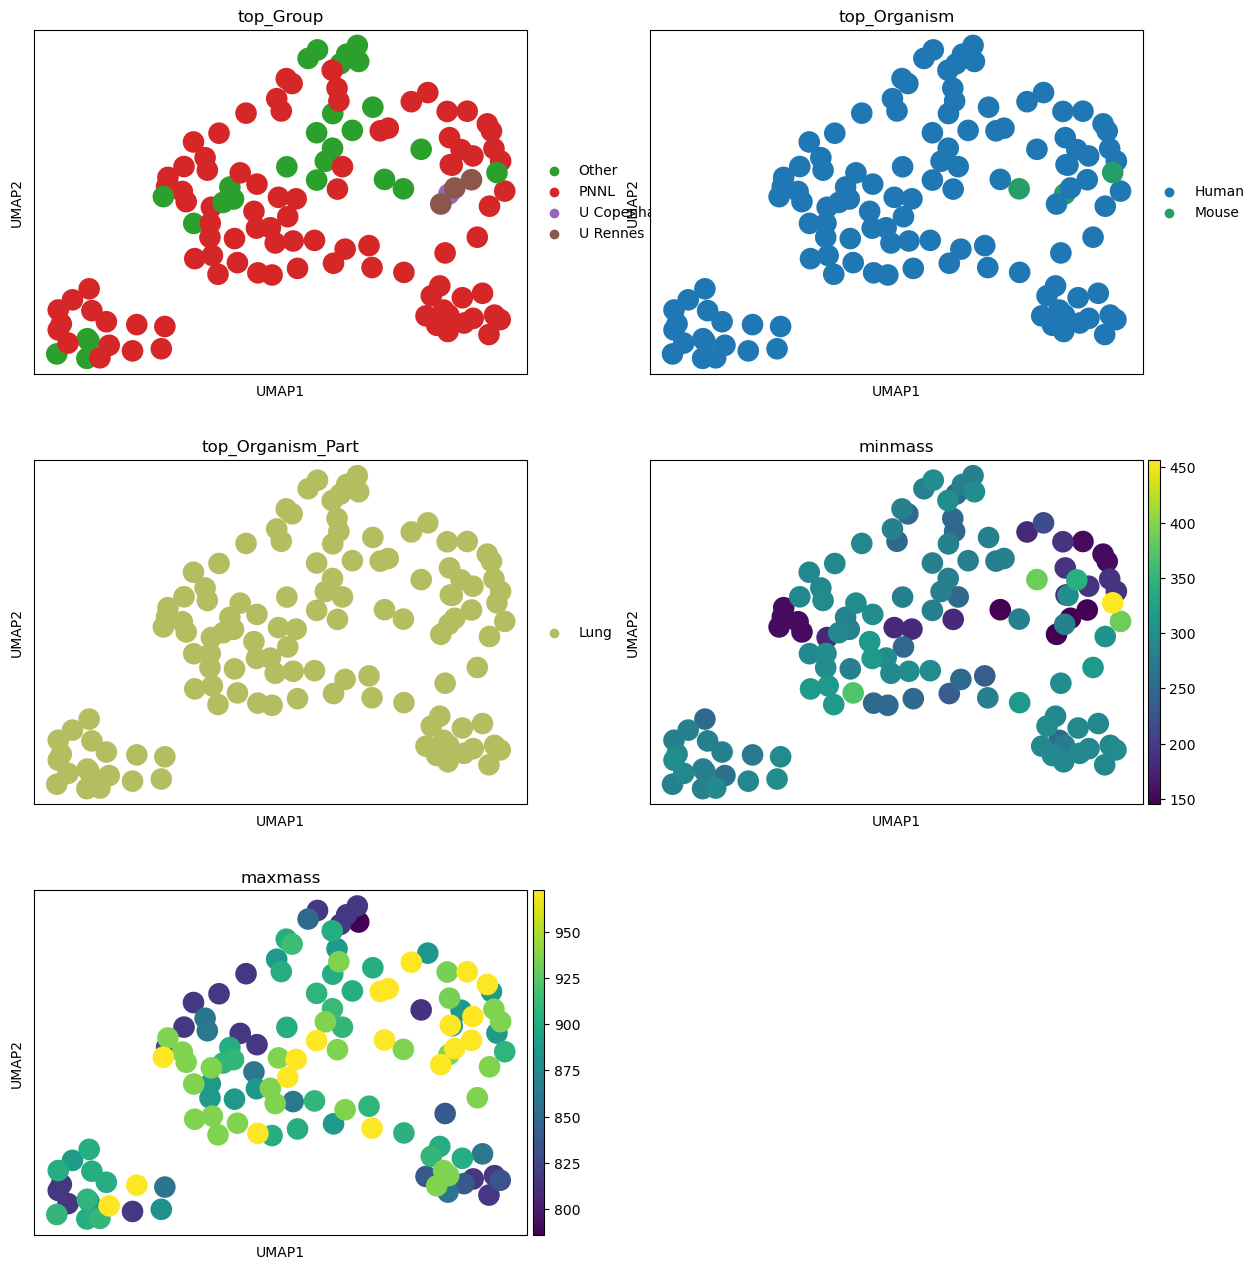

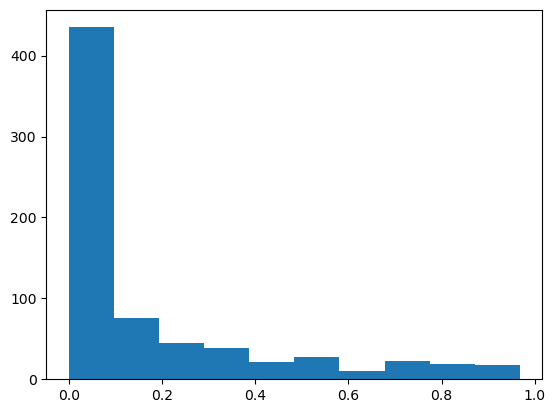

In [49]:
tissue = 'Lung'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [78]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C39H78NO8P  -  ['PC(15:0/16:0)', 'PC(16:0/15:0)', 'PE(14:0/20:0)', 'PE(16:0/18:0)']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C47H93N2O6P  -  ['SM(d18:1/24:1(15Z))', 'SM(d18:2(4E,14Z)/24:0)']
C16H18O9S  -  ['{4-[2-hydroxy-3-(2,4,6-trihydroxyphenyl)propyl]-2-methoxyphenyl}oxidanesulfonic acid', '{[1-(4-hydroxy-3-methoxyphenyl)-3-(2,4,6-trihydroxyphenyl)propan-2-yl]oxy}sul

### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


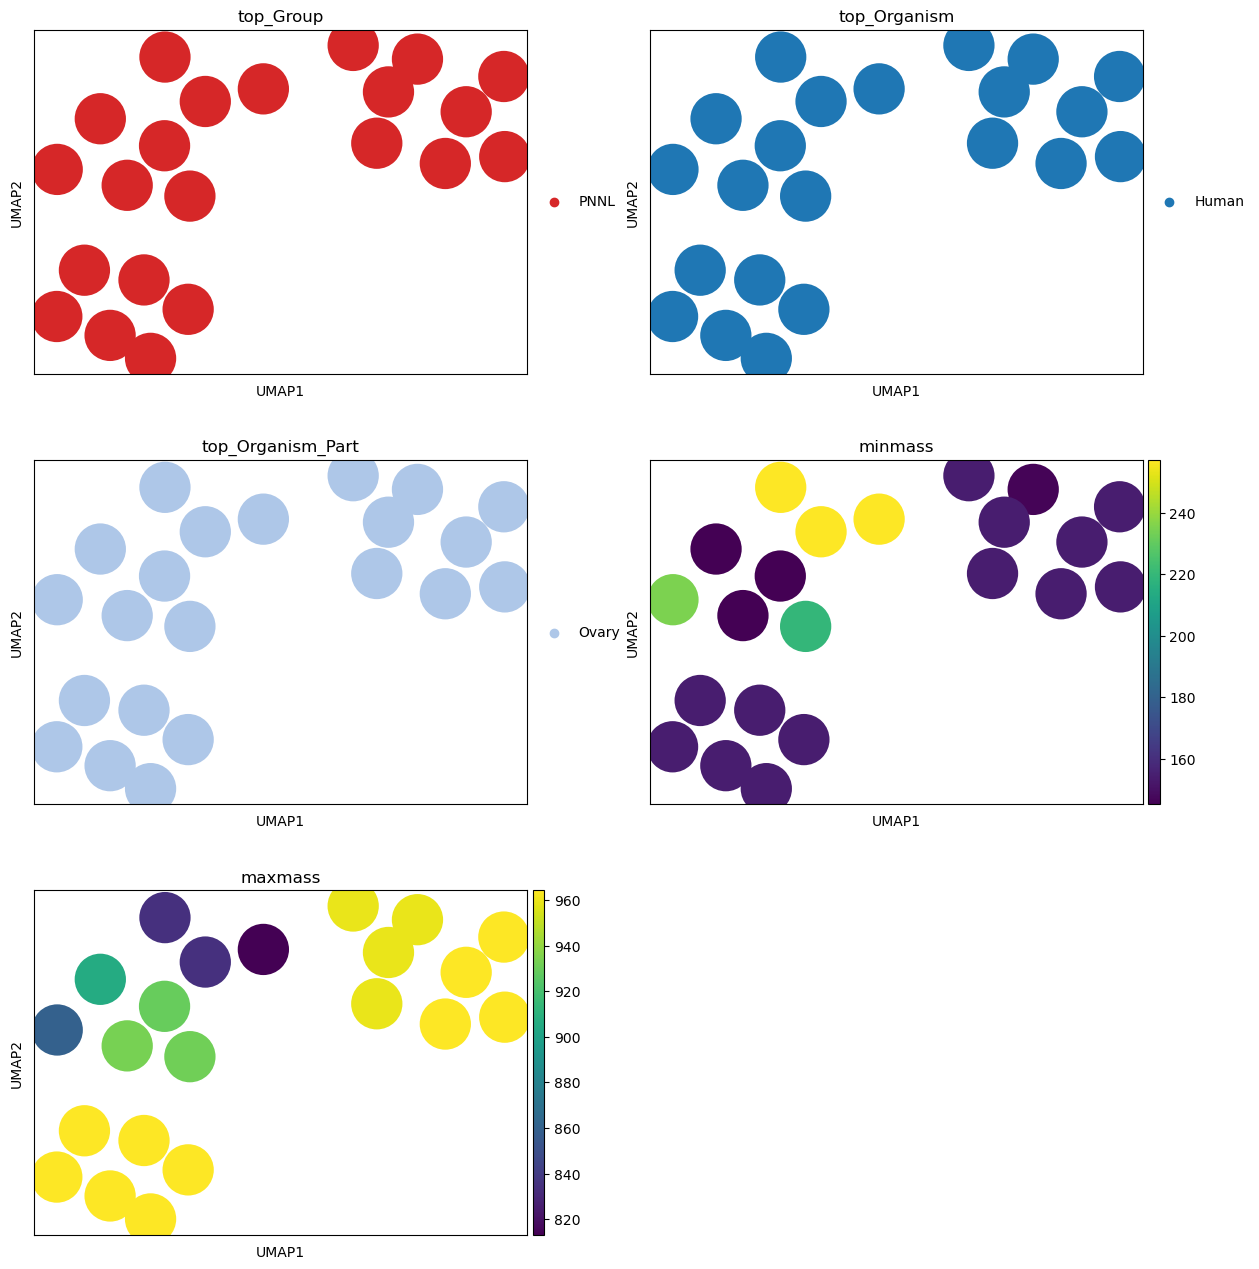

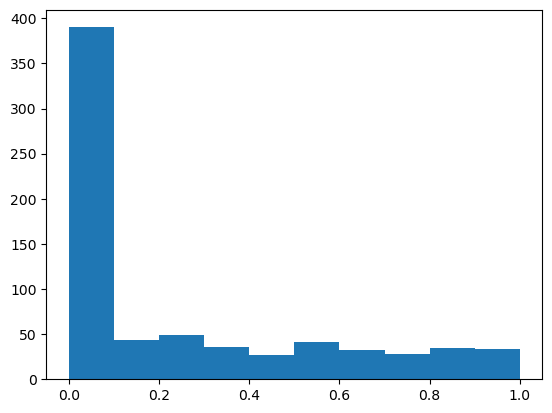

In [50]:
tissue = 'Ovary'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [80]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C37H70O5  -  ['DG(14:0/20:1(11Z)/0:0)', 'DG(14:1(9Z)/20:0/0:0)', 'DG(16:0/18:1(11Z)/0:0)', 'DG(16:0/18:1(9Z)/0:0)']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C13H17NO3  -  ['Pandamarilactam 3x']
C26H52NO7P  -  ['LysoPC(18:1(9Z)/0:0)', 'LysoPC(18:1(11Z)/0:0)', 'LysoPC(0:0/18:1(9Z))']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C37H66O4  -  ['Montecristin']
C61H104O6  -  ['TG(18:2(9Z,12Z)/20:1(11Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:1(9Z)/22:5(7Z,10Z,13Z,16Z,19Z))', 'TG(18:2(9Z,12Z)/18:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'TG(14:0/22:1(13Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C12H16N5O8P  -  ['Acetyl adenylate']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z

### Skin

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


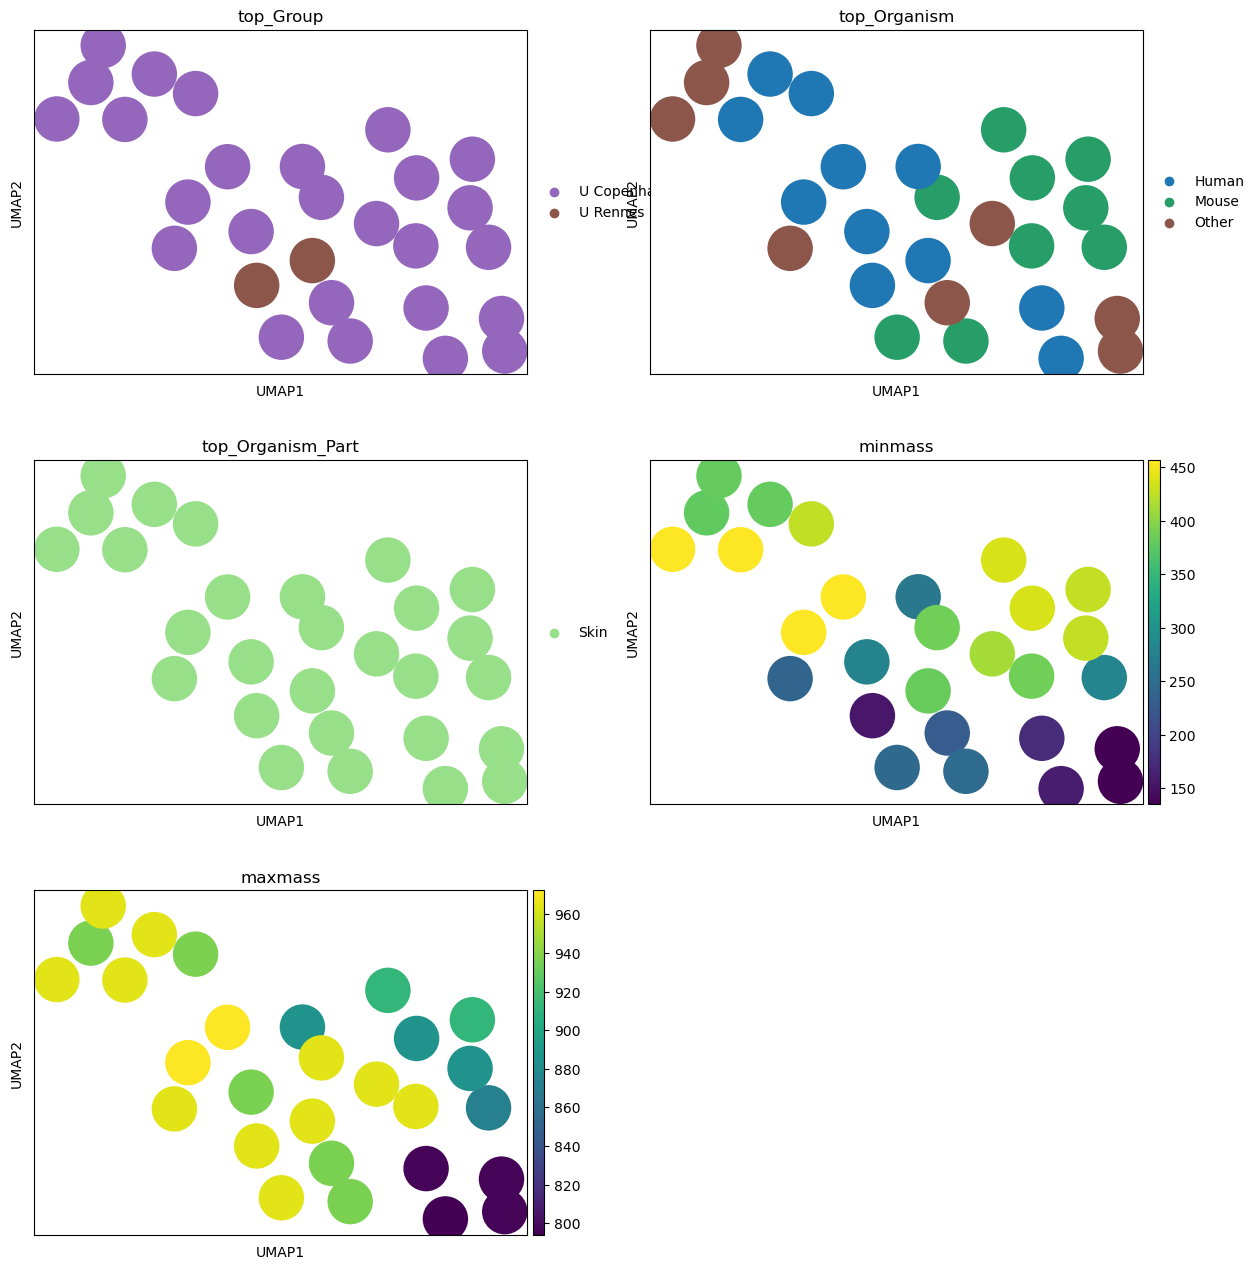

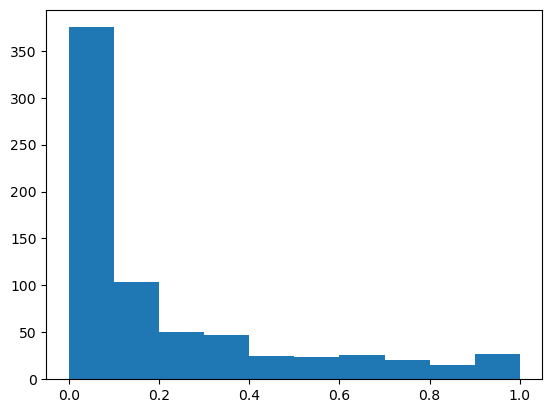

In [51]:
tissue = 'Skin'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [82]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C26H50NO7P  -  ['LysoPC(18:2(9Z,12Z)/0:0)', 'LysoPC(0:0/18:2(9Z,12Z))']
C57H102O6  -  ['TG(16:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:1(9Z)/18:1(9Z)/18:2(9Z,12Z))']
C43H71O8P  -  ['PA(18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(18:2(9Z,12Z)/22:5(4Z,7Z,10Z,13Z,16Z))', 'PA(18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z))']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C37H66O4  -  ['Montecristin']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C43H76NO8P  -  ['PC(15:0/20:5(5Z,8Z,11Z,14Z,17Z))', 'PC(20:5(5Z,8Z,11Z,14Z,17Z)/15:0)', 'PE(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PE(16:0/22:5(7Z,10Z,13Z,16Z,19Z))']
C39H78NO8P  -  ['PC(15:0/16:0)', 'PC(16:0/15:0)', 'PE(14:0/20:0)', 'PE(16

## Tissue similarity

Dataset thresholding

In [86]:
freq_tab = pd.DataFrame(tissue_mol_freq).transpose()
freq_tab[freq_tab.isna()] = 0

In [87]:
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

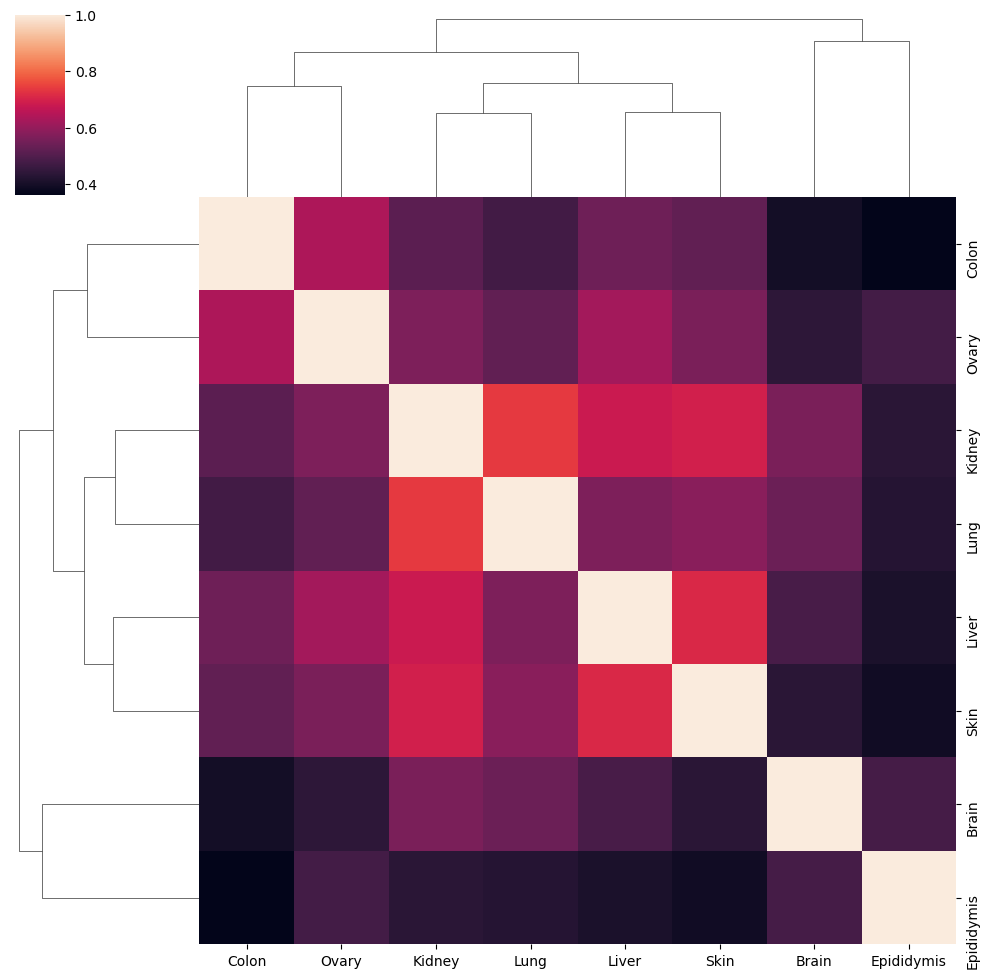

In [88]:
sns.clustermap(sim_tab)

## Next step

Look into the top ions that two tissues share

In [167]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.6] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

In [168]:
pos = nx.spring_layout(g, k=1.3)

/tmp/ipykernel_89/3834781060.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


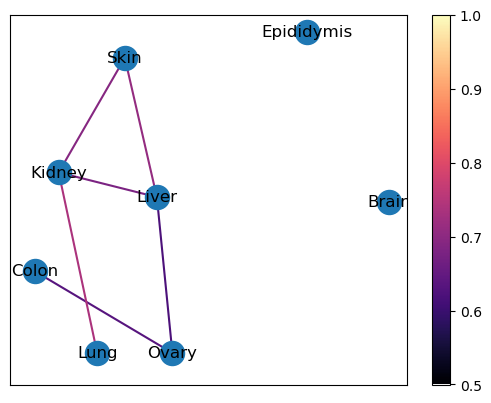

In [169]:
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.5
vmax=1
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

In [175]:
tmp = sim_tab.melt()['value']
tmp = tmp[tmp<1]

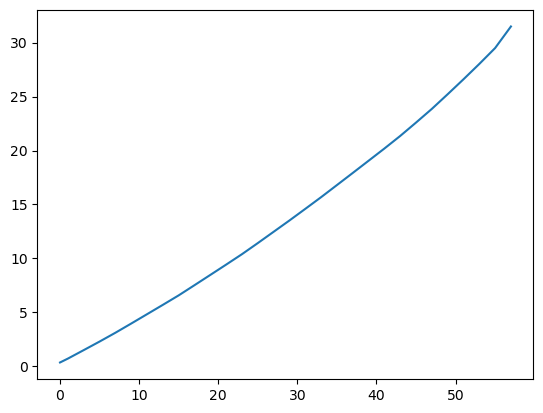

In [182]:
plt.plot(np.cumsum(tmp.sort_values().values), '-')

# Negative

In [52]:
adata_neg = adata[adata.obs['Polarity']=='Negative',:]

sc.pp.filter_genes(adata_neg, min_cells=100) # 200
sc.pp.filter_cells(adata_neg, min_genes=20) # 50
#sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_neg.var['mass'] = [Formula(x).mass for x in adata_neg.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [53]:
pd.DataFrame(adata_neg.var.index).to_csv(os.path.join(enrichment_dir, f'bg_neg.csv'))

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

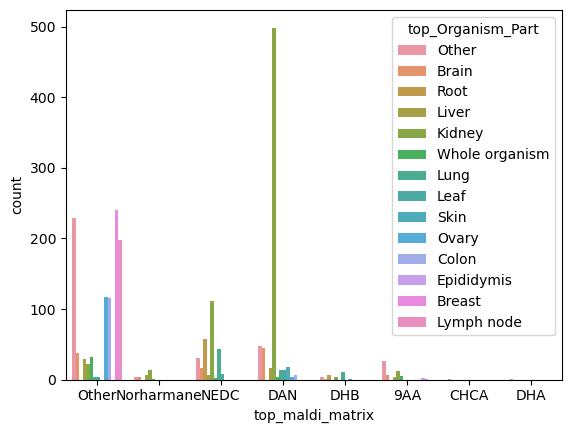

In [54]:
sns.countplot(data=adata_neg.obs, x='top_maldi_matrix', hue='top_Organism_Part')

## Matrix

Not sure which matrix should be used. Either `NEDC` or `DAN`. The workflow should probably be tested with both of them.

In [60]:
adata_neg_matrix = adata_neg[adata_neg.obs['top_maldi_matrix']=='DAN',:]

sc.tl.pca(adata_neg_matrix)
sc.pp.neighbors(adata_neg_matrix, metric='cosine')
sc.tl.leiden(adata_neg_matrix)
sc.tl.umap(adata_neg_matrix)

utils.update_minmax_mass(adata_neg_matrix)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


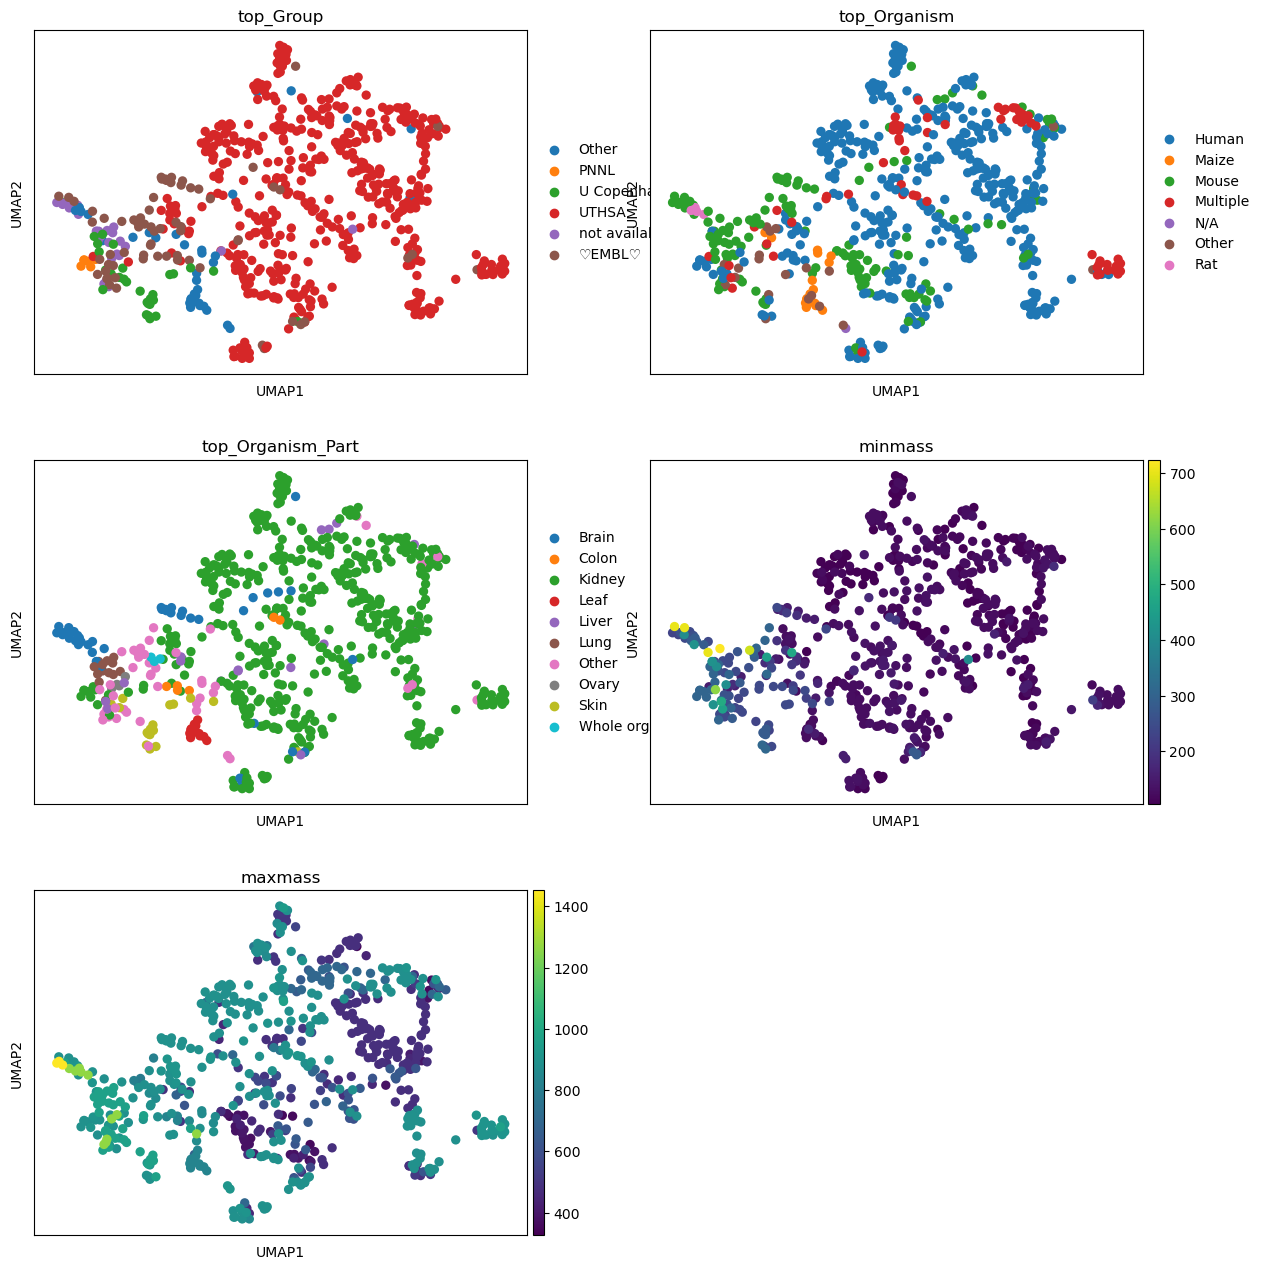

In [61]:
sc.pl.umap(adata_neg_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


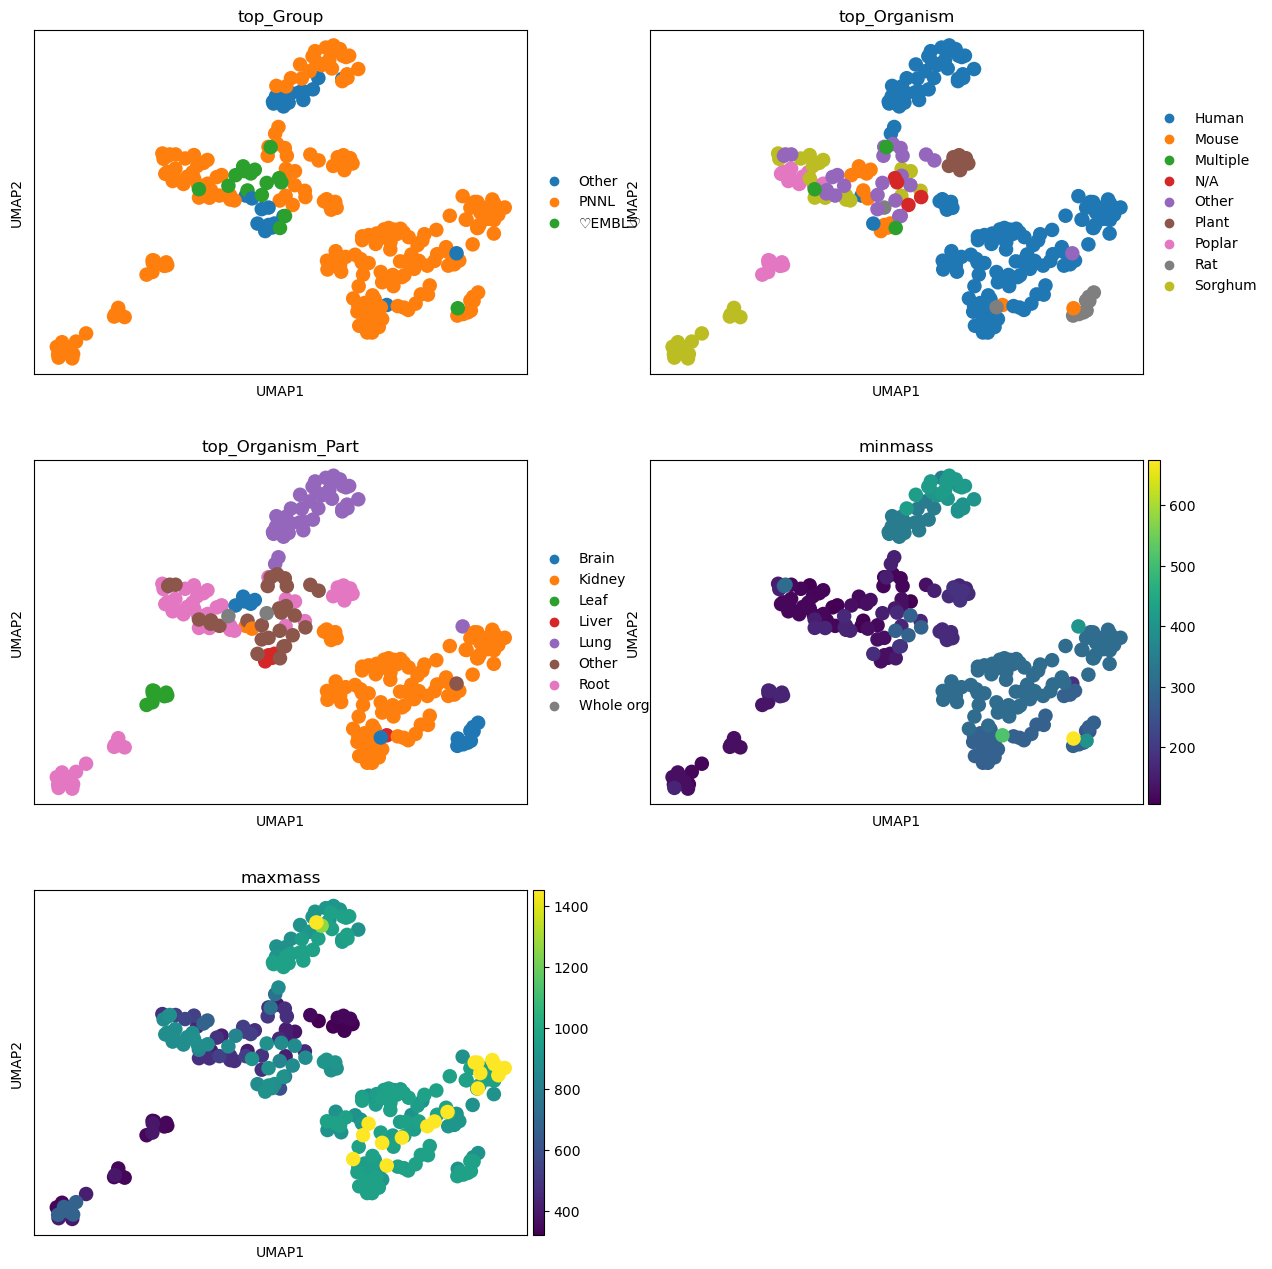

In [59]:
sc.pl.umap(adata_neg_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [63]:
os.listdir(enrichment_dir)

['features_pos_Brain.csv',
 'bg_pos.csv',
 'features_pos_Colon.csv',
 'features_pos_Epididymis.csv',
 'features_pos_Kidney.csv',
 'features_pos_Liver.csv',
 'features_pos_Lung.csv',
 'features_pos_Ovary.csv',
 'features_pos_Skin.csv',
 'enrichment_pos_wBG_features_pos_Brain.rds',
 'bg_neg.csv']

In [64]:
enrichment_dir

'/g/alexandr/tim/metaspace_evaluation/230201/enrichment'